In [1]:
import os
import sys
from transformers import AutoTokenizer
import torch
from datasets import load_dataset
from balm import common_utils
from balm.models.utils import load_trained_model, load_pretrained_pkd_bounds
from balm.configs import Configs
from balm.models import BALM
import matplotlib.pyplot as plt
import time
import datamol as dm
import pandas as pd
import seaborn as sns
import numpy as np

/Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/hannahbaumann/miniforge3/envs/balm/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can igno

In [2]:
def plot_seaborn(labels, predictions):
    rmse = get_rmse(torch.tensor(labels), torch.tensor(predictions))
    pearson = get_pearson(torch.tensor(labels), torch.tensor(predictions))
    spearman = get_spearman(torch.tensor(labels), torch.tensor(predictions))
    ci = get_ci(torch.tensor(labels), torch.tensor(predictions))
    
    print(f"RMSE: {rmse}")
    print(f"Pearson: {pearson}")
    print(f"Spearman: {spearman}")
    print(f"CI: {ci}")
    
    ax = sns.regplot(x=labels, y=predictions)
    ax.set_title(f"SARS")
    ax.set_xlabel(r'Experimental $pK_d$',fontsize=12)
    ax.set_ylabel(r'Predicted $pK_d$',fontsize=12)

In [3]:
def zero_shot_pred(X_train, y_true, target):
    model = BALM(configs.model_configs)
    model = load_trained_model(model, configs.model_configs, is_training=True)
    model = model.to(device)
    print(len(X_train))
    start = time.time()
    labels = []
    predictions = []
    for inx, sample in enumerate(X_train.tolist()):
        # Prepare input
        protein_inputs = protein_tokenizer(sars, return_tensors="pt").to(device)
        drug_inputs = drug_tokenizer(sample, return_tensors="pt").to(device)
        inputs = {
            "protein_input_ids": protein_inputs["input_ids"],
            "protein_attention_mask": protein_inputs["attention_mask"],
            "drug_input_ids": drug_inputs["input_ids"],
            "drug_attention_mask": drug_inputs["attention_mask"],
        }
        prediction = model(inputs)["cosine_similarity"]
        prediction = model.cosine_similarity_to_pkd(prediction, pkd_upper_bound=pkd_upper_bound, pkd_lower_bound=pkd_lower_bound)
        
        label = torch.tensor(y_true.tolist()[inx])
    
        print(f"Predicted pKd: {prediction.item()} | True pKd: {label.item()}")
        predictions.append(prediction.item())
        labels.append(label.item())
    print(f"Time taken for zero-shot prediction: {time.time() - start}")

    return predictions, labels

In [4]:
CHALLENGE = "antiviral-potency-2025"

In [5]:
import polaris as po
competition = po.load_competition(f"asap-discovery/{CHALLENGE}")

[2025-03-10 10:19:44] INFO     The version of Polaris that was used to create the artifact (0.11.0) ]8;id=88087;file:///Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=659966;file:///Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/polaris/_artifact.py#92\92]8;;\
                               is different from the currently installed version of Polaris                        
                               (0.11.8).                                                                           

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=194555;file:///Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=900349;file:///Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/polaris/dataset/_base.py#181\181]8;;\
                               enough, consider caching the dataset first using                                    
                               CompetitionSpecification.cache() for more performant data access.                   

In [6]:
competition.cache()

Output()

[10:19:46] Copying to destination                                                                      ]8;id=455466;file:///Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=577331;file:///Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/polaris/dataset/_base.py#380\380]8;;\
           /Users/hannahbaumann/Library/Caches/polaris/datasets/11c09fd0-7ec2-402d-ae27-32726bc5b134/d             
           ata.zarr                                                                                                

           For large Zarr archives, this may take a while.                                             ]8;id=514139;file:///Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=718314;file:///Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/polaris/dataset/_base.py#381\381]8;;\

[10:19:47]  Success: Copying Zarr keys                                                                ]8;id=585192;file:///Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=859224;file:///Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/polaris/utils/context.py#53\53]8;;\

            Success: Copying Zarr archive                                                             ]8;id=919898;file:///Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=374497;file:///Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/polaris/utils/context.py#53\53]8;;\

'/Users/hannahbaumann/Library/Caches/polaris/datasets/11c09fd0-7ec2-402d-ae27-32726bc5b134'

In [7]:
train, test = competition.get_train_test_split()

In [8]:
tdf = train.as_dataframe()

In [9]:
tdf_test = test.as_dataframe()

# Load Pretrained BindingDB BALM

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")

In [11]:
config_filepath = "../../BALM/default_configs/balm_peft.yaml"
configs = Configs(**common_utils.load_yaml(config_filepath))

# Load the model
model = BALM(configs.model_configs)
model = load_trained_model(model, configs.model_configs, is_training=False)
model.to(device)
model.eval()
# Pretrained pKd lower and upper bounds
pkd_lower_bound, pkd_upper_bound = load_pretrained_pkd_bounds(configs.model_configs.checkpoint_path)

# Load the tokenizers
protein_tokenizer = AutoTokenizer.from_pretrained(
    configs.model_configs.protein_model_name_or_path
)
drug_tokenizer = AutoTokenizer.from_pretrained(
    configs.model_configs.drug_model_name_or_path
)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 128,160 || all params: 148,923,641 || trainable%: 0.0861
trainable params: 221,184 || all params: 3,648,624 || trainable%: 6.0621
Loading checkpoint from BALM/bdb-cleaned-r-esm-lokr-chemberta-loha-cosinemse


/Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/balm/models/utils.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


Merging protein model with its adapter
Merging drug model with its adapter


In [12]:
sars = 'SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVTSGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTSEDMLNPNYEDLLIRKSNHNFLVQAGNVQLRVIGHSMQNCVLKLKVDTANPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNFTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGNFYGPFVDRQTAQAAGTDTTITVNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCASLKELLQNGMNGRTILGSALLEDEFTPFDVVRQCSGVT'

In [13]:
mers = "SGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPADQLSDPNYDALLISMTNHSFSVQKHIGAPANLRVVGHAMQGTLLKLTVDVANPSTPAYTFTTVKPGAAFSVLACYNGRPTGTFTVVMRPNYTIKGSFLCGSCGSVGYTKEGSVINFCYMHQMELANGTHTGSAFDGTMYGAFMDKQVHQVQLTDKYCSVNVVAWLYAAILNGCAWFVKPNRTSVVSFNEWALANQFTEFVGTQSVDMLAVKTGVAIEQLLYAIQQLYTGFQGKQILGSTMLEDEFTPEDVNMQIMGVSGLVKMSHPSGDVEACMVQVTCGSMTLNGLWLDNTVWCPRHVMCPADQLSDPNYDALLISMTNHSFSVQKHIGAPANLRVVGHAMQGTLLKLTVDVANPSTPAYTFTTVKPGAAFSVLACYNGRPTGTFTVVMRPNYTIKGSFLCGSCGSVGYTKEGSVINFCYMHQMELANGTHTGSAFDGTMYGAFMDKQVHQVQLTDKYCSVNVVAWLYAAILNGCAWFVKPNRTSVVSFNEWALANQFTEFVGTQSVDMLAVKTGVAIEQLLYAIQQLYTGFQGKQILGSTMLEDEFTPEDVNMQIMGV"

## Few shot learning

###   SARS

In [14]:
tdf_sars = tdf.dropna(subset='pIC50 (SARS-CoV-2 Mpro)')

In [15]:
model_sars = BALM(configs.model_configs)
model_sars = load_trained_model(model_sars, configs.model_configs, is_training=True)
model_sars = model_sars.to(device)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 128,160 || all params: 148,923,641 || trainable%: 0.0861
trainable params: 221,184 || all params: 3,648,624 || trainable%: 6.0621
Loading checkpoint from BALM/bdb-cleaned-r-esm-lokr-chemberta-loha-cosinemse


/Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/balm/models/utils.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


Merging protein model with its adapter
Merging drug model with its adapter
protein_projection.weight
protein_projection.bias
drug_projection.weight
drug_projection.bias
trainable params: 262,656 || all params: 152,485,577 || trainable%: 0.17224973349446682


In [16]:
# Define a function that applies the cosine similarity conversion to a single example
# This is VERY IMPORTANT since BALM uses cosine similarity
def add_cosine_similarity(example, pkd_upper_bound, pkd_lower_bound):
    example['cosine_similarity'] = (
        (example['pIC50 (SARS-CoV-2 Mpro)'] - pkd_lower_bound)
        / (pkd_upper_bound - pkd_lower_bound)
        * 2
        - 1
    )
    return example

# Use map to apply the function across the entire dataset
train_sars_data = tdf_sars.apply(lambda x: add_cosine_similarity(x, pkd_upper_bound, pkd_lower_bound), axis=1)

In [17]:
from torch.optim import AdamW

NUM_EPOCHS = 10
optimizer = AdamW(
    params=[
        param
        for name, param in model_sars.named_parameters()
    ],
    lr=configs.model_configs.model_hyperparameters.learning_rate,
)

start = time.time()
for epoch in range(NUM_EPOCHS):
    model_sars.train()  # Set the model to training mode
    total_loss = 0.0  # To track the loss for each epoch

    for _, sample in train_sars_data.iterrows():
        # Prepare input
        protein_inputs = protein_tokenizer(sars, return_tensors="pt").to(device)
        drug_inputs = drug_tokenizer(sample["CXSMILES"], return_tensors="pt").to(device)
        # Move labels to the appropriate device and ensure it's a tensor
        labels = torch.tensor([sample["cosine_similarity"]], dtype=torch.float32).to(device)

        inputs = {
            "protein_input_ids": protein_inputs["input_ids"],
            "protein_attention_mask": protein_inputs["attention_mask"],
            "drug_input_ids": drug_inputs["input_ids"],
            "drug_attention_mask": drug_inputs["attention_mask"],
            "labels": labels,  # Add labels for training
        }

        # Forward pass
        outputs = model_sars(inputs)

        # Assume the model's output dictionary contains 'loss'
        loss = outputs["loss"]

        # Backpropagation
        optimizer.zero_grad()  # Zero out the gradients to avoid accumulation
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        total_loss += loss.item()
    
    # Log the loss for this epoch
    avg_loss = total_loss / len(train_sars_data)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}")

print("Training complete! Time taken: ", time.time() - start)

Epoch [1/10], Loss: 0.0537
Epoch [2/10], Loss: 0.0448
Epoch [3/10], Loss: 0.0416
Epoch [4/10], Loss: 0.0394
Epoch [5/10], Loss: 0.0400
Epoch [6/10], Loss: 0.0396
Epoch [7/10], Loss: 0.0386
Epoch [8/10], Loss: 0.0377
Epoch [9/10], Loss: 0.0374
Epoch [10/10], Loss: 0.0381
Training complete! Time taken:  1714.5232179164886


In [20]:
model_sars = model_sars.eval()

predictions_sars = []
for _, sample in tdf_test.iterrows():
    # Prepare input
    protein_inputs = protein_tokenizer(sars, return_tensors="pt").to(device)
    drug_inputs = drug_tokenizer(sample["CXSMILES"], return_tensors="pt").to(device)
    inputs = {
        "protein_input_ids": protein_inputs["input_ids"],
        "protein_attention_mask": protein_inputs["attention_mask"],
        "drug_input_ids": drug_inputs["input_ids"],
        "drug_attention_mask": drug_inputs["attention_mask"],
    }
    prediction = model_sars(inputs)["cosine_similarity"]
    prediction = model_sars.cosine_similarity_to_pkd(prediction, pkd_upper_bound=pkd_upper_bound, pkd_lower_bound=pkd_lower_bound)

    print(f"Predicted pKd: {prediction.item()}")
    predictions_sars.append(prediction.item())
print(f"Time taken for {len(tdf_test)} protein-ligand pairs: {time.time() - start}")

Predicted pKd: 5.931648254394531
Predicted pKd: 6.096720218658447
Predicted pKd: 6.316147804260254
Predicted pKd: 5.871420860290527
Predicted pKd: 6.075333118438721
Predicted pKd: 6.364169120788574
Predicted pKd: 6.591361045837402
Predicted pKd: 6.64089822769165
Predicted pKd: 5.795050621032715
Predicted pKd: 5.694810390472412
Predicted pKd: 5.593613624572754
Predicted pKd: 6.223623275756836
Predicted pKd: 6.446412563323975
Predicted pKd: 7.134296894073486
Predicted pKd: 6.442206859588623
Predicted pKd: 6.477745056152344
Predicted pKd: 6.454024314880371
Predicted pKd: 6.835148811340332
Predicted pKd: 5.103014945983887
Predicted pKd: 6.345027446746826
Predicted pKd: 6.339457988739014
Predicted pKd: 6.316542148590088
Predicted pKd: 6.231197357177734
Predicted pKd: 6.304614543914795
Predicted pKd: 6.576588153839111
Predicted pKd: 6.209480285644531
Predicted pKd: 6.28034782409668
Predicted pKd: 5.863784313201904
Predicted pKd: 6.5664472579956055
Predicted pKd: 5.861268043518066
Predicted p

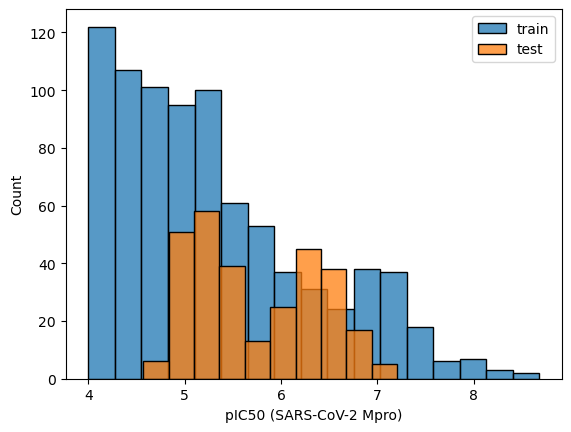

In [21]:
sns.histplot(data=tdf_sars, x='pIC50 (SARS-CoV-2 Mpro)')
sns.histplot(data=predictions_sars)
plt.legend(labels=['train', 'test'])

### MERS

In [22]:
tdf_mers = tdf.dropna(subset='pIC50 (MERS-CoV Mpro)')

In [23]:
model_mers = BALM(configs.model_configs)
model_mers = load_trained_model(model_mers, configs.model_configs, is_training=True)
model_mers = model_mers.to(device)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 128,160 || all params: 148,923,641 || trainable%: 0.0861
trainable params: 221,184 || all params: 3,648,624 || trainable%: 6.0621
Loading checkpoint from BALM/bdb-cleaned-r-esm-lokr-chemberta-loha-cosinemse


/Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/balm/models/utils.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


Merging protein model with its adapter
Merging drug model with its adapter
protein_projection.weight
protein_projection.bias
drug_projection.weight
drug_projection.bias
trainable params: 262,656 || all params: 152,485,577 || trainable%: 0.17224973349446682


In [24]:
# Define a function that applies the cosine similarity conversion to a single example
# This is VERY IMPORTANT since BALM uses cosine similarity
def add_cosine_similarity(example, pkd_upper_bound, pkd_lower_bound):
    example['cosine_similarity'] = (
        (example['pIC50 (MERS-CoV Mpro)'] - pkd_lower_bound)
        / (pkd_upper_bound - pkd_lower_bound)
        * 2
        - 1
    )
    return example

# Use map to apply the function across the entire dataset
train_mers_data = tdf_mers.apply(lambda x: add_cosine_similarity(x, pkd_upper_bound, pkd_lower_bound), axis=1)

In [25]:
from torch.optim import AdamW

NUM_EPOCHS = 10
optimizer = AdamW(
    params=[
        param
        for name, param in model_mers.named_parameters()
    ],
    lr=configs.model_configs.model_hyperparameters.learning_rate,
)

start = time.time()
for epoch in range(NUM_EPOCHS):
    model_mers.train()  # Set the model to training mode
    total_loss = 0.0  # To track the loss for each epoch

    for _, sample in train_mers_data.iterrows():
        # Prepare input
        protein_inputs = protein_tokenizer(mers, return_tensors="pt").to(device)
        drug_inputs = drug_tokenizer(sample["CXSMILES"], return_tensors="pt").to(device)
        # Move labels to the appropriate device and ensure it's a tensor
        labels = torch.tensor([sample["cosine_similarity"]], dtype=torch.float32).to(device)

        inputs = {
            "protein_input_ids": protein_inputs["input_ids"],
            "protein_attention_mask": protein_inputs["attention_mask"],
            "drug_input_ids": drug_inputs["input_ids"],
            "drug_attention_mask": drug_inputs["attention_mask"],
            "labels": labels,  # Add labels for training
        }

        # Forward pass
        outputs = model_mers(inputs)

        # Assume the model's output dictionary contains 'loss'
        loss = outputs["loss"]

        # Backpropagation
        optimizer.zero_grad()  # Zero out the gradients to avoid accumulation
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        total_loss += loss.item()
    
    # Log the loss for this epoch
    avg_loss = total_loss / len(train_mers_data)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}")

print("Training complete! Time taken: ", time.time() - start)

Epoch [1/10], Loss: 0.0513
Epoch [2/10], Loss: 0.0465
Epoch [3/10], Loss: 0.0445
Epoch [4/10], Loss: 0.0441
Epoch [5/10], Loss: 0.0437
Epoch [6/10], Loss: 0.0428
Epoch [7/10], Loss: 0.0432
Epoch [8/10], Loss: 0.0421
Epoch [9/10], Loss: 0.0412
Epoch [10/10], Loss: 0.0427
Training complete! Time taken:  4166.305280923843


In [26]:
model_mers = model_mers.eval()

predictions_mers = []
for _, sample in tdf_test.iterrows():
    # Prepare input
    protein_inputs = protein_tokenizer(mers, return_tensors="pt").to(device)
    drug_inputs = drug_tokenizer(sample["CXSMILES"], return_tensors="pt").to(device)
    inputs = {
        "protein_input_ids": protein_inputs["input_ids"],
        "protein_attention_mask": protein_inputs["attention_mask"],
        "drug_input_ids": drug_inputs["input_ids"],
        "drug_attention_mask": drug_inputs["attention_mask"],
    }
    prediction = model_mers(inputs)["cosine_similarity"]
    prediction = model_mers.cosine_similarity_to_pkd(prediction, pkd_upper_bound=pkd_upper_bound, pkd_lower_bound=pkd_lower_bound)

    print(f"Predicted pKd: {prediction.item()}")
    predictions_mers.append(prediction.item())
print(f"Time taken for {len(tdf_test)} protein-ligand pairs: {time.time() - start}")

Predicted pKd: 5.124138832092285
Predicted pKd: 5.100592613220215
Predicted pKd: 5.130181312561035
Predicted pKd: 4.872617721557617
Predicted pKd: 4.9869208335876465
Predicted pKd: 5.149333953857422
Predicted pKd: 5.397085666656494
Predicted pKd: 5.373982906341553
Predicted pKd: 4.803249359130859
Predicted pKd: 4.69140625
Predicted pKd: 4.740262031555176
Predicted pKd: 5.108410358428955
Predicted pKd: 5.089628219604492
Predicted pKd: 5.916336536407471
Predicted pKd: 5.224494934082031
Predicted pKd: 5.273767471313477
Predicted pKd: 5.294435024261475
Predicted pKd: 5.764235019683838
Predicted pKd: 4.425209045410156
Predicted pKd: 5.152710914611816
Predicted pKd: 5.2500457763671875
Predicted pKd: 4.980072498321533
Predicted pKd: 5.118600845336914
Predicted pKd: 5.067632675170898
Predicted pKd: 5.444244384765625
Predicted pKd: 5.0880513191223145
Predicted pKd: 5.257948875427246
Predicted pKd: 4.877411842346191
Predicted pKd: 5.296996116638184
Predicted pKd: 5.036980628967285
Predicted pKd:

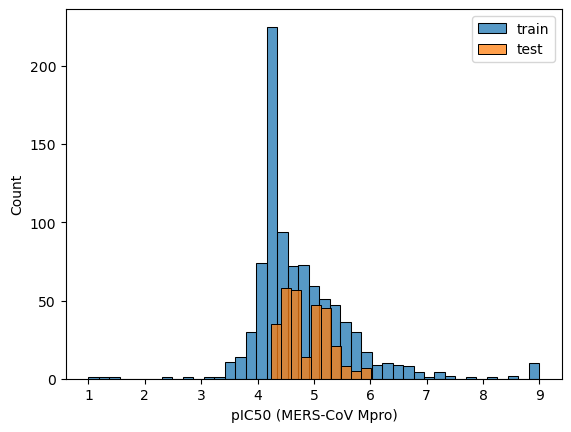

In [27]:
sns.histplot(data=tdf_mers, x='pIC50 (MERS-CoV Mpro)')
sns.histplot(data=predictions_mers)
plt.legend(labels=['train', 'test'])

In [92]:
y_pred = {}
y_pred['pIC50 (SARS-CoV-2 Mpro)'] = predictions_sars
y_pred['pIC50 (MERS-CoV Mpro)'] = predictions_mers

In [93]:
y_pred

{'pIC50 (SARS-CoV-2 Mpro)': [5.816550254821777,
  6.040087699890137,
  6.2275824546813965,
  5.831760883331299,
  6.015883445739746,
  6.262660026550293,
  6.521389961242676,
  6.562859058380127,
  5.707439422607422,
  5.582667827606201,
  5.527900695800781,
  6.158298015594482,
  6.3490824699401855,
  7.054938793182373,
  6.3887176513671875,
  6.3858795166015625,
  6.372504234313965,
  6.774399280548096,
  5.167107582092285,
  6.312045097351074,
  6.268171310424805,
  6.212973117828369,
  6.151200771331787,
  6.2398362159729,
  6.475409507751465,
  6.067739486694336,
  6.222430229187012,
  5.779682636260986,
  6.359099388122559,
  5.742358207702637,
  6.337283611297607,
  6.423543453216553,
  6.471183776855469,
  6.434807777404785,
  6.1390533447265625,
  6.229709148406982,
  6.390213966369629,
  6.124080181121826,
  6.516223907470703,
  6.406838893890381,
  6.3284502029418945,
  6.598521709442139,
  6.24502420425415,
  6.24502420425415,
  6.746976375579834,
  6.746976375579834,
  6.5

In [95]:
import json
with open('balm_few_shot.json', 'w') as fp:
    json.dump(y_pred, fp)

In [94]:
competition.submit_predictions(
    predictions=y_pred,
    prediction_name="BALM_potency_few_shot",
    prediction_owner="hbaumann",
    report_url="https://github.com/meyresearch/polaris_challenge/tree/potency",
    # github_url="https://github.com/meyresearch/polaris_challenge/tree/potency",
    description="BALM, few shot learning",
    user_attributes={"Method": "BALM"},
)

[17:31:26]  Success: Submitting competition predictions                                               ]8;id=65343;file:///Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=895419;file:///Users/hannahbaumann/miniforge3/envs/balm/lib/python3.10/site-packages/polaris/utils/context.py#53\53]8;;\